#<h2>**1 Importing various libraries for the data analysis:**</h2>

In [ ]:
!pip install stop-words
!pip install py7zr

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=c26e816898ff164e09da1f9215b70677e0ac1b025cb9d75858997ac679bf7f2f
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 13.7MB 317kB/s 


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import shutil
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from py7zr import unpack_7zarchive
import math
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from scipy.sparse import coo_matrix, hstack
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from prettytable import PrettyTable
from sklearn.linear_model import RidgeCV
import pickle
import zipfile
from tqdm import tqdm
import os
from sklearn.linear_model import Ridge
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from stop_words import get_stop_words
from collections import Counter
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, GRU, Dense,Flatten
from tensorflow.keras.models import Model,load_model
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from contextlib import contextmanager
tf.keras.backend.clear_session()

#<h2>**2 Utility Functions:**</h2>

In [ ]:
def split_categories(category):
    '''
    function that splits the category column in the dataset and creates 3 new columns:
    'main_category','sub_cat_1','sub_cat_2'
    '''
    try:
      sub_cat_1,sub_cat_2,sub_cat_3 = category.split("/")
      return sub_cat_1,sub_cat_2,sub_cat_3
    except:
      return ("No label","No label","No label")

def create_split_categories(data):
    '''
    function that creates 3 new columns using split_categories function
    : 'main_category','sub_cat_1','sub_cat_2'
    '''
    #https://medium.com/analytics-vidhya/mercari-price-suggestion-challenge-a-machine-learning-regression-case-study-9d776d5293a0
    data['main_category'],data['sub_cat_1'],data['sub_cat_2']=zip(*data['category_name'].\
                                                                  apply(lambda x: split_categories(x)))

def log_price(price):
    return np.log1p(price)#changes

#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
def countwords(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0

def fill_nan(dataset):
    '''
    Function to fill the NaN values in various columns
    '''
    dataset["item_description"].fillna("No description yet",inplace=True)
    dataset["brand_name"].fillna("missing",inplace=True)
    dataset["category_name"].fillna("missing",inplace=True)

def get_dummies_item_id_shipping(df):
    df['item_condition_id'] = df["item_condition_id"].astype("category")
    df['shipping'] = df["shipping"].astype("category")
    item_id_shipping = csr_matrix(pd.get_dummies(df[['item_condition_id', 'shipping']],\
                                                      sparse=True).values)
    return item_id_shipping

def one_hot_encode(train,test):
    '''
    Function to one hot encode the categorical columns
    '''
    vectorizer = CountVectorizer(token_pattern='.+')
    
    vectorizer = vectorizer.fit(train['category_name'].values) # fit has to happen only on train data
    column_cat = vectorizer.transform(test['category_name'].values)

    #vectorizing the main_category column
    vectorizer = vectorizer.fit(train['main_category'].values) # fit has to happen only on train data
    column_mc = vectorizer.transform(test['main_category'].values)
    
    #vectorizing sub_cat_1 column
    vectorizer = vectorizer.fit(train['sub_cat_1'].values) # fit has to happen only on train data
    column_sb1 = vectorizer.transform(test['sub_cat_1'].values)
    
    #vectorizing sub_cat_2 column
    vectorizer = vectorizer.fit(train['sub_cat_2'].values) # fit has to happen only on train data
    column_sb2 = vectorizer.transform(test['sub_cat_2'].values)

    #vectorizing brand column
    vectorizer = vectorizer.fit(train['brand_name'].astype(str)) # fit has to happen only on train data
    brand_encodes = vectorizer.transform(test['brand_name'].astype(str))

    #https://github.com/numpy/numpy/issues/11666
   # vectorizer = CountVectorizer(vocabulary= list(train['shipping'].unique()),binary = True)
    #shipping
    #vectorizer = vectorizer.fit(train['shipping'].astype(str)) # fit has to happen only on train data
    #column_shipping = vectorizer.transform(test['shipping'].astype(str))
    
    #vectorizer = CountVectorizer(vocabulary= list(train['item_condition_id'].unique()),binary = True)
    #item_condition_id
    #vectorizer = vectorizer.fit(train['item_condition_id'].astype(str)) # fit has to happen only on train data
    #column_item_id = vectorizer.transform(test['item_condition_id'].astype(str))
    
    print("created OHE columns for main_category,sub_cat_1,sub_cat_2\n")
    print(column_cat.shape)
    print(column_mc.shape)
    print(column_sb1.shape)
    print(column_sb2.shape)
    print(brand_encodes.shape)
    #print(column_shipping.shape)
    #print(column_item_id.shape)
    print("="*100)
    return column_cat,column_mc,column_sb1,column_sb2,brand_encodes

def rank_category(dataset,column_name):
    '''This function takes a column name which is categorical and returns the categories with rank'''
    counter = dataset[column_name].value_counts().index.values
    total = list(dataset[column_name])
    ranked_cat = {}
    for i in range(1,len(counter)+1):
        ranked_cat.update({counter[i-1] : i})
    return ranked_cat,len(counter)

def encode_ranked_category(train,test,column):
    '''
    This function calls the rank_category function and returns the encoded category column    '''
    train[column] = train[column].astype('category')
    test[column] = test[column].astype('category')
    
    cat_list = list(train[column].unique())
    ranked_cat_tr,count = rank_category(train,column)

    encoded_col_tr = []
    encoded_col_te = []

    for category in train[column]:
        encoded_col_tr.append(ranked_cat_tr[category])

    for category in test[column]:
        if category in cat_list:
            encoded_col_te.append(ranked_cat_tr[category])
        else:
            encoded_col_te.append(0)
    
    encoded_col_tr = np.asarray(encoded_col_tr)
    encoded_col_te = np.asarray(encoded_col_te)
    return encoded_col_tr,encoded_col_te,count

def tokenize_text(train,test,column):
    #AAIC course reference
    global t
    t = Tokenizer()
    t.fit_on_texts(train[column].str.lower())
    vocab_size = len(t.word_index) + 1
    # integer encode the documents
    encoded_text_tr = t.texts_to_sequences(train[column].str.lower())
    encoded_text_te = t.texts_to_sequences(test[column].str.lower())
    return encoded_text_tr,encoded_text_te,vocab_size

def data_gru(train,test):
    
    global max_length,desc_size,name_size
    encoded_brand_tr,encoded_brand_te,brand_len = encode_ranked_category(train,test,'brand_name')
    #encoded_cat_tr,encoded_cat_te,cat_len = encode_ranked_category(train,test,'category_name')
    encoded_main_cat_tr,encoded_main_cat_te,main_cat_len = encode_ranked_category(train,test,'main_category')
    encoded_sub_cat_1_tr,encoded_sub_cat_1_te,sub_cat1_len = encode_ranked_category(train,test,'sub_cat_1')
    encoded_sub_cat_2_tr,encoded_sub_cat_2_te,sub_cat2_len = encode_ranked_category(train,test,'sub_cat_2')
    
    tokenized_desc_tr,tokenized_desc_te,desc_size = tokenize_text(train,test,'item_description')
     
    tokenized_name_tr,tokenized_name_te,name_size = tokenize_text(train,test,'name')
      
    max_length = 160
    desc_tr_padded = pad_sequences(tokenized_desc_tr, maxlen=max_length, padding='post')
    desc_te_padded = pad_sequences(tokenized_desc_te, maxlen=max_length, padding='post')
    del tokenized_desc_tr,tokenized_desc_te

    name_tr_padded = pad_sequences(tokenized_name_tr, maxlen=10, padding='post')
    name_te_padded = pad_sequences(tokenized_name_te, maxlen=10, padding='post')
    del tokenized_name_tr,tokenized_name_te

    gc.collect()

    train_inputs = [name_tr_padded,desc_tr_padded,encoded_brand_tr.reshape(-1,1),\
                    encoded_main_cat_tr.reshape(-1,1),encoded_sub_cat_1_tr.reshape(-1,1),\
                    encoded_sub_cat_2_tr.reshape(-1,1),train['shipping'],\
                    train['item_condition_id'],train['wc_desc'],\
                    train['wc_name']]
    test_inputs = [name_te_padded,desc_te_padded,encoded_brand_te.reshape(-1,1),\
                    encoded_main_cat_te.reshape(-1,1),encoded_sub_cat_1_te.reshape(-1,1),\
                    encoded_sub_cat_2_te.reshape(-1,1),test['shipping'],\
                    test['item_condition_id'],test['wc_desc'],\
                    test['wc_name']]
    
    item_condition_counter = train['item_condition_id'].value_counts().index.values

    list_var = [brand_len,main_cat_len,sub_cat1_len,sub_cat2_len,len(item_condition_counter)]
    
    return train_inputs,test_inputs,list_var

def construct_GRU(train,var_list,drop_out_list):
    #GRU input layer for name
    input_name =  tf.keras.layers.Input(shape=(10,), name='name')
    embedding_name = tf.keras.layers.Embedding(name_size, 20)(input_name)
    gru_name = tf.keras.layers.GRU(8)(embedding_name)
    #flatten1 = tf.keras.layers.Flatten()(lstm_out)

    #GRU input layer for description
    input_desc =  tf.keras.layers.Input(shape=(max_length,), name='desc')
    embedding_desc = tf.keras.layers.Embedding(desc_size, 60)(input_desc)
    gru_desc = tf.keras.layers.GRU(16)(embedding_desc)

    #input layer for brand_name
    input_brand =  tf.keras.layers.Input(shape=(1,), name='brand')
    embedding_brand = tf.keras.layers.Embedding(var_list[0] + 1, 10)(input_brand)
    flatten1 = tf.keras.layers.Flatten()(embedding_brand)

    #categorical input layer main_category
    input_cat = tf.keras.layers.Input(shape=(1,), name='main_cat')
    Embed_cat = tf.keras.layers.Embedding(var_list[1] + 1, \
                                          10,input_length=1)(input_cat)
    flatten2 = tf.keras.layers.Flatten()(Embed_cat)

    #categorical input layer sub_cat_1
    input_subcat1 = tf.keras.layers.Input(shape=(1,), name='subcat1')
    Embed_subcat1 = tf.keras.layers.Embedding(var_list[2] + 1, \
                                              10,input_length=1)(input_subcat1)
    flatten3 = tf.keras.layers.Flatten()(Embed_subcat1)

    #categorical input layer sub_cat_2
    input_subcat2 = tf.keras.layers.Input(shape=(1,), name='subcat2')
    Embed_subcat2 = tf.keras.layers.Embedding(var_list[3] + 1, \
                                              10,input_length=1)(input_subcat2)
    flatten4 = tf.keras.layers.Flatten()(Embed_subcat2)

    #categorical input layer shipping
    input_shipping = tf.keras.layers.Input(shape=(1,), name='shipping')
    # Embed_shipping = tf.keras.layers.Embedding(var_list[3] + 1, \
    #                                            7,input_length=1)(input_shipping)
    # flatten5 = tf.keras.layers.Flatten()(Embed_shipping)

    #categorical input layer item_condition_id
    input_item = tf.keras.layers.Input(shape=(1,), name='item_condition_id')
    Embed_item = tf.keras.layers.Embedding(var_list[4] + 1, \
                                           5,input_length=1)(input_item)
    flatten5 = tf.keras.layers.Flatten()(Embed_item)

    #numerical input layer
    desc_len_input = tf.keras.layers.Input(shape=(1,), name='description_length')
    desc_len_embd = tf.keras.layers.Embedding(DESC_LEN,5)(desc_len_input)
    flatten6 = tf.keras.layers.Flatten()(desc_len_embd)

    #name_len input layer
    name_len_input = tf.keras.layers.Input(shape=(1,), name='name_length')
    name_len_embd = tf.keras.layers.Embedding(NAME_LEN,5)(name_len_input)
    flatten7 = tf.keras.layers.Flatten()(name_len_embd)

    # concatenating the outputs
    concat_layer = tf.keras.layers.concatenate(inputs=[gru_name,gru_desc,flatten1,flatten2,flatten3,flatten4,input_shipping,flatten5,\
                                                       flatten6,flatten7],name="concatenate")
    #dense layers
    Dense_layer1 = tf.keras.layers.Dense(units=512,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_l")(concat_layer)
    dropout_1 = tf.keras.layers.Dropout(drop_out_list[0],name='dropout_1')(Dense_layer1)
    batch_n1 = tf.keras.layers.BatchNormalization()(dropout_1)
    
    Dense_layer2 = tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_2")(batch_n1)
    dropout_2 = tf.keras.layers.Dropout(drop_out_list[1],name='dropout_2')(Dense_layer2)
    batch_n2 = tf.keras.layers.BatchNormalization()(dropout_2)

    Dense_layer3 = tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_3")(batch_n2)
    dropout_3 = tf.keras.layers.Dropout(drop_out_list[2],name='dropout_3')(Dense_layer3)

    Dense_layer4 = tf.keras.layers.Dense(units=64,activation='relu',kernel_initializer='he_normal',\
                                         name="Dense_4")(dropout_3)
    dropout_4 = tf.keras.layers.Dropout(drop_out_list[3],name='dropout_4')(Dense_layer4)
    
    #output_layer
    final_output = tf.keras.layers.Dense(units=1,activation='linear',name='output_layer')(dropout_4)

    model = tf.keras.Model(inputs=[input_name,input_desc,input_brand,input_cat,input_subcat1,input_subcat2,\
                                   input_shipping,input_item,desc_len_input,name_len_input],
                           outputs=[final_output])
    # we specified the model input and output
    print(model.summary())
    img_path = "/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/image_plots/GRU_model_2_lr.png"
    plot_model(model, to_file=img_path, show_shapes=True, show_layer_names=True) 
    return model

#https://www.tensorflow.org/guide/keras/train_and_evaluate
def compile_predict_GRU(train_input,test_input,y_train,variable_list,drop_list):
    filepath="GRU_lr-{epoch:03d}-{val_loss:.3f}.hdf5"
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/',\
     #                                        write_graph=True)

    #call_backs = [model_checkpoint,tensorboard]
    #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
    def scheduler(epoch):
        if epoch < 2:
          return 0.005
        else:
          return 0.001

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    
    #https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
    x_train = train_input
    model= construct_GRU(x_train,variable_list,drop_list)
    model.compile(optimizer='adam', loss='mean_squared_error')
    ######the below fit is used for model 1 & 2 alone##############
    # call_backs = [model_checkpoint]
    # for i in range(3):
    #     with timer(f'epoch {i + 1}'):
    #         model_history= model.fit(x_train, y_train,\
    #                                            batch_size=2**(8 + i),\
    #                                            epochs=1, verbose=1,\
    #                                            callbacks=call_backs,\
    #                                            validation_split = 0.1)
    
    ###########the below lines were used for fitting the model 3 & 4#########
    call_backs = [model_checkpoint,lr_schedule]
    model.fit(x_train, y_train, epochs=3,batch_size=2**10, callbacks=call_backs,validation_split=0.1)

    pred_on_train = model.predict(x_train,batch_size = 2**10,verbose = 1)
    pred_on_test = model.predict(test_input,batch_size = 2**10,verbose = 1)
    return pred_on_train,pred_on_test

def get_tensorboard_ready():
    ! rm -rf ./logs/ 
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #logdir = ""
    print(logdir)
    return logdir

def hyperparameter_tuning_random(x,y,model_estimator,param_dict,cv_no):
    start = time.time()
    hyper_tuned = GridSearchCV(estimator = model_estimator, param_grid = param_dict,\
                                    return_train_score=True, scoring = 'neg_mean_squared_error',\
                                    cv = cv_no, \
                                    verbose=2, n_jobs = -1)
    hyper_tuned.fit(x,y)
    print("\n######################################################################\n")
    print ('Time taken for hyperparameter tuning is {} sec\n'.format(time.time()-start))
    print('The best parameters_: {}'.format(hyper_tuned.best_params_))
    return hyper_tuned.best_params_

def rmsle_compute(y_true, y_pred):
    #https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
    assert len(y_true) == len(y_pred)
    score = np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
    return score

def scale_back(x):
    '''
    Function to inverse transform the scaled values
    '''
    x= np.expm1(y_scalar.inverse_transform(x.reshape(-1,1))[:,0])#changes
    return x

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')


In [ ]:
def pickle_dump(*args,filename = 'file'):
    # Saving the objects:
    argv = args
    list_variable = [i for i in argv]
    dir_name = "/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/"
    filename_suffix = "pkl"
    #https://stackoverflow.com/questions/7132861/build-the-full-path-filename-in-python
    file_path = os.path.join(dir_name, filename + "." + filename_suffix)
    with open(file_path, 'wb') as f:
        pickle.dump(list_variable, f)
def read_pickle_dump(*args,filename = 'file'):
    argv = args
    variable_list = [i for i in argv]
    # Getting back the objects:
    dir_name = "/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/"
    filename_suffix = "pkl"
    #https://stackoverflow.com/questions/7132861/build-the-full-path-filename-in-python
    file_path = os.path.join(dir_name, filename + "." + filename_suffix)
    with open(file_path,'rb') as f:
        variable_list = pickle.load(f)
        print("Returning the variables\n")
    return variable_list        

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#<h2>**3 GRU Model:**</h2>

In [ ]:
############################
#step1: load the train file
############################
gc.collect()
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/train.tsv',sep='\t')
#test = x
print("Finished loading the files....\n")
#print("train: {0}\ntest: {1}\n".format(train.shape,test.shape))

Finished loading the files....



In [ ]:
##########################################################
#step2: Data cleaning and preprocessing of train and test
##########################################################
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
train = train.drop(train[(train.price < 3.0)].index)
fill_nan(train)
# fill_nan(test)
print("filled nan\n")

train['wc_desc'] = train['item_description'].apply(lambda x: countwords(x))
#test['wc_desc'] = test['item_description'].apply(lambda x: countwords(x))
train['wc_name'] = train['name'].apply(lambda x: countwords(x))
#train['wc_name'] = train['name'].apply(lambda x: countwords(x))
create_split_categories(train)
# create_split_categories(test)
print("Completed data cleaning and preprocessing\n")

# train test split
X_train, X_test= train_test_split(train, test_size=0.20, random_state=123)
print("shape of X_train: {}".format(X_train.shape))
print("shape of X_test: {}".format(X_test.shape))

#target variable
global y_scalar,DESC_LEN,NAME_LEN
y_scalar = StandardScaler()#changes
y_train = y_scalar.fit_transform(log_price(X_train['price']).values.reshape(-1, 1))#changes
y_test = y_scalar.transform(log_price(X_test['price']).values.reshape(-1, 1))#

filled nan

Completed data cleaning and preprocessing

shape of X_train: (1185328, 13)
shape of X_test: (296333, 13)


**<h3>Some explanation on tokenization and padding used in GRU:</h3>**

Item descriptions and name columns are used in GRU. Their respective tokenization and padding happens in *data_gru* function. Shown below is a sample code snippet of tokenization for better understanding of the data after the process. Also explained the global constants considered for the model.

In [ ]:
tokenized_desc_tr,tokenized_desc_te,desc_size = tokenize_text(X_train,X_test,'item_description')
tokenized_name_tr,tokenized_name_te,name_size = tokenize_text(X_train,X_test,'name')

sample data after tokenziation:

In [ ]:
tokenized_desc_tr[:2]

[[390,
  802,
  200,
  3921,
  332,
  133,
  1557,
  123,
  233,
  390,
  375,
  35,
  251,
  107,
  11,
  54,
  181,
  2889,
  560,
  222],
 [12, 63, 68]]

Given below is the vocabulary sizes of item_description and name:

In [ ]:
desc_size

206541

In [ ]:
name_size

118013

Calculating the percentage of data points falling above a particular length. This is done for choosing the padding length after tokenizing the text columns such as item_description and name

In [ ]:
print("% of sequence containing len > 160 is")
len(X_train[X_train.wc_desc > 160])/X_train.shape[0]*100

% of sequence containing len > 160 is


0.7443190959638517

In [ ]:
print("% of name containing len > 10 is")
len(X_train[X_train.wc_name > 10])/X_train.shape[0]*100

% of name containing len > 10 is


0.005522059605520423

Description length and name length have been included as a separate input layer. Given below is the lengths used for embedding the respective columns. The text length plays a significant role in improving the model performance and the inspiration for adding such feature came from [here](https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755)

In [ ]:
train['wc_name'].max()

17

In [ ]:
train['wc_desc'].max()

245

In [ ]:
DESC_LEN = train.wc_desc.max() + 1
NAME_LEN = train.wc_name.max() + 1

In [ ]:
tf.keras.backend.clear_session()

**Preparing the data for model:**

In [ ]:
##############################################
#step 3: getting the data ready for RNN model
##############################################
train_inputs,test_inputs,list_var = data_gru(X_train,X_test)

Constructing different models from the same data but using different dropout rates and also with differing learning rates.

#**<h3>3.1 Model 1</h3>**

learning_rate = default

drop_outs = 0.10,0.10,0.20,0.20

In [ ]:
#################################
#step:4 compiling and predicting
#################################
dropout_list = [0.10,0.10,0.20,0.20] #list of dropouts used in different layers
preds_m1_tr,preds_m1_te = compile_predict_GRU(train_inputs,test_inputs,y_train,list_var,dropout_list)
#del train_inputs,test_inputs,list_var
#gc.collect()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
main_cat (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
print("RMSLE on train data: {}\n".format(rmsle_compute(X_train['price'],scale_back(preds_m1_tr))))
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(preds_m1_te))))

RMSLE on train data: 0.39556506235020006

RMSLE on test data: 0.43623946074075887



In [ ]:
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(preds_m1_te))))

RMSLE on test data: 0.43623946074075887



#<h3>3.2 Model 2</h3>

learning_rate = default

drop_outs = 0.10,0.20,0.30,0.40


In [ ]:
#################################
#step:4 compiling and predicting
#################################
dropout_list = [0.10,0.20,0.30,0.40]
tr_preds_m2,te_preds_m2 = compile_predict_GRU(train_inputs,test_inputs,y_train,list_var,dropout_list)
del train_inputs,test_inputs,list_var
gc.collect()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
main_cat (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

164778

In [ ]:
print("RMSLE on train data: {}\n".format(rmsle_compute(X_train['price'],scale_back(tr_preds_m2))))
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(te_preds_m2))))

RMSLE on train data: 0.4050869841026714

RMSLE on test data: 0.4408661171182735



In [ ]:
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(te_preds_m2))))

RMSLE on test data: 0.4408661171182735



In [ ]:
pickle_dump(preds_m1_tr,te_preds_m2,filename='predictions_gru_20')

In [ ]:
preds_m1_tr,te_preds_m2 = read_pickle_dump('preds_m1_tr','te_preds_m2',filename='predictions_gru_20')

Returning the variables



#<h3>3.3 Model 3</h3>

learning_rate = 0.005 for epoch 1 & 2, 0.001 for epoch 3

drop_outs = 0.10,0.10,0.20,0.20

In [ ]:
#################################
#step:4 compiling and predicting
#################################
dropout_list = [0.10,0.10,0.20,0.20]
tr_preds_m1_lr,te_preds_m1_lr = compile_predict_GRU(train_inputs,test_inputs,y_train,list_var,dropout_list)
del train_inputs,test_inputs,list_var
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
main_cat (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

80969

In [ ]:
print("RMSLE on train data: {}\n".format(rmsle_compute(X_train['price'],scale_back(tr_preds_m1_lr))))
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(te_preds_m1_lr))))

RMSLE on train data: 0.37836234863310303

RMSLE on test data: 0.4313011302602914



In [ ]:
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(te_preds_m1_lr))))

RMSLE on test data: 0.4313011302602914



#<h3>3.4 Model 4</h3>
 
learning_rate = 0.005 for epoch 1 & 2, 0.001 for epoch 3

drop_outs = 0.10,0.20,0.30,0.40

In [ ]:
#################################
#step:4 compiling and predicting
#################################
dropout_list = [0.10,0.20,0.30,0.40]
tr_preds_m2_lr,te_preds_m2_lr = compile_predict_GRU(train_inputs,test_inputs,y_train,list_var,dropout_list)
del train_inputs,test_inputs,list_var
gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
desc (InputLayer)               [(None, 160)]        0                                            
__________________________________________________________________________________________________
brand (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
main_cat (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

79847

In [ ]:
print("RMSLE on train data: {}\n".format(rmsle_compute(X_train['price'],scale_back(tr_preds_m2_lr))))
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(te_preds_m2_lr))))

RMSLE on train data: 0.3934700910162936

RMSLE on test data: 0.43666765129841567



In [ ]:
print("RMSLE on test data: {}\n".format(rmsle_compute(X_test['price'],scale_back(te_preds_m2_lr))))

RMSLE on test data: 0.43666765129841567



storing predictions:

In [ ]:
pickle_dump(te_preds_m1_lr,te_preds_m2_lr,filename='predictions_gru_lr_20')

In [ ]:
te_preds_m1_lr,te_preds_m2_lr = read_pickle_dump('te_preds_m1_lr','te_preds_m2_lr',filename='predictions_gru_lr')

Returning the variables



#<h3>3.5 Model Average Ensembling:</h3>

Ensembling Model 1 & 2:

In [ ]:
#https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

y_hats = np.array([preds_m1_te,te_preds_m2]) #making an array out of all the predictions
# mean across ensembles
mean_preds = np.mean(y_hats, axis=0)
print("RMSLE on test: {}".format(rmsle_compute(X_test['price'],scale_back(mean_preds))))

RMSLE on test: 0.4331924408303648


Ensembling Model 3 & 4:

In [ ]:
#https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/

#https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/#comment-539557

y_hats = np.array([te_preds_m1_lr,te_preds_m2_lr]) #making an array out of all the predictions
# mean across ensembles
mean_preds = np.mean(y_hats, axis=0)
print("RMSLE on test: {}".format(rmsle_compute(X_test['price'],scale_back(mean_preds))))

RMSLE on test: 0.4286869951689969


#<h2>**Results:**</h2>

In [ ]:
# Please compare all your models using Prettytable library
#https://stackoverflow.com/questions/43583847/python-pretty-table-with-color-output
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
C = "\033[1;37;40m" 
N = "\033[0m" # Reset
print(C+"Summarization of different Model outputs\n"+N)
x.field_names = ["GRU_Model_no.", "dropout_rate", "training_condition","Test_RMSLE"]
x.add_row([1,(0.10,0.10,0.20,0.20),'optimizer: Adam\nlearning_rate: default',0.436])
x.add_row([2,(0.10,0.20,0.30,0.40),'optimizer: Adam\nlearning_rate: default',0.441])
x.add_row([3,(0.10,0.10,0.20,0.20),'optimizer: Adam\nlearning_rate: 0.005(epoch 1&2)\n0.001(epoch 3)',0.431])
x.add_row([4,(0.10,0.20,0.30,0.40),'optimizer: Adam\nlearning_rate: 0.005(epoch 1&2)\n0.001(epoch 3)',0.437])
print(x)


Summarization of different Model outputs

+---------------+----------------------+---------------------------------+------------+
| GRU_Model_no. |     dropout_rate     |        training_condition       | Test_RMSLE |
+---------------+----------------------+---------------------------------+------------+
|       1       | (0.1, 0.1, 0.2, 0.2) |         optimizer: Adam         |   0.436    |
|               |                      |      learning_rate: default     |            |
|       2       | (0.1, 0.2, 0.3, 0.4) |         optimizer: Adam         |   0.441    |
|               |                      |      learning_rate: default     |            |
|       3       | (0.1, 0.1, 0.2, 0.2) |         optimizer: Adam         |   0.431    |
|               |                      | learning_rate: 0.005(epoch 1&2) |            |
|               |                      |          0.001(epoch 3)         |            |
|       4       | (0.1, 0.2, 0.3, 0.4) |         optimizer: Adam         |   0

Ensembling results:

In [ ]:
y = PrettyTable()
Y = "\033[1;33;40m" # Yellow
N = "\033[0m" # Reset
C = "\033[1;37;40m"
print(C+"Model output from ensembling\n"+N)
y.field_names = ["Model", "Test_RMSLE"]
y.add_row(['Model 1 & 2 Ensembling','0.433'])
y.add_row(['Model 3 & 4 Ensembling',Y+'0.429'+N])
print(y)

Model output from ensembling

+------------------------+------------+
|         Model          | Test_RMSLE |
+------------------------+------------+
| Model 1 & 2 Ensembling |   0.433    |
| Model 3 & 4 Ensembling |   0.429    |
+------------------------+------------+


Score from Kaggle:
Used the same code to train in kaggle and got the score. I have used model 3 and 4 here for ensembling.

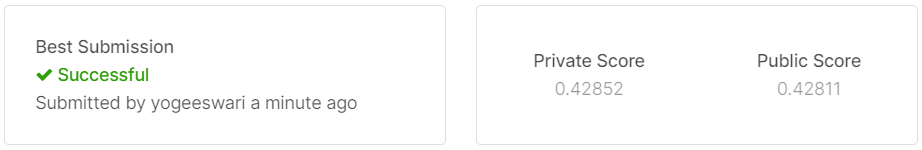

References:

In [ ]:
#https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/
#https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755